In [144]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns

print(stopwords.words('english'))
subreddit = 'ukraine'
wordfilter = ["ukraine", "ukrainian", "ukraini", "russia", "russian", "putin", "zelensky", "zelenskyy", "nato", "kiev", "kyiv", "sanction", "oil", "gas", "swift", "moscow", "kremlin", "azov", "vladimir", "war"]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [145]:
file_c = f'./data/preprocessed/conspiracy_preprocessed_filtered.csv'
df_c = pd.read_csv(file_c)
file_u = f'./data/preprocessed/ukraine_preprocessed_filtered.csv'
df_u = pd.read_csv(file_u)

C:\Users\1408\AppData\Local\Temp\ipykernel_2224\285732340.py:4: DtypeWarning: Columns (86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df_u = pd.read_csv(file_u)


In [146]:
def removeDeleted(dataframe):
    dataframe['title'] = dataframe['title'].apply(str) 
    dataframe['selftext'] = dataframe['selftext'].apply(str) 
    dataframe.loc[dataframe['title'].isin({ "remove", "delete", "nan"}),'title'] = ""
    dataframe.loc[dataframe['selftext'].isin({ "remove", "delete", "nan"}),'selftext'] = ""
    dataframe['wholetext'] = dataframe['title'] + " " + dataframe['selftext']
    dataframe = dataframe[['selftext','title','wholetext']]

def removeStopWords(data, stop):
    submissions = []
    for string in data:
        string = [word for word in string.split() if word not in stop]
        #submission = [word for word in submission.split()]
        submissions.append(' '.join(string))
    return submissions

In [147]:
removeDeleted(df_c)
removeDeleted(df_u)
wholetext_c = df_c.wholetext.values
wholetext_u = df_u.wholetext.values
submissions_c = removeStopWords(wholetext_c, nltk.corpus.stopwords.words('english'))
submissions_u = removeStopWords(wholetext_u, nltk.corpus.stopwords.words('english'))

In [148]:
from sklearn.feature_extraction.text import CountVectorizer

def colorWordCloud(df_ngram, hue):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 80%%, %d%%)" % (hue, 20 + 70 * df_ngram[word])
    return my_tf_color_func_inner

def createWordCloud(ngram_range, max_features, submissions, color, hue):
    
    countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngrams = countvec.fit_transform(submissions)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = countvec.vocabulary_
    df_ngram = pd.DataFrame([(k,count_values[i]) for k,i in vocab.items()]).rename(columns={0: 'ngram', 1:'frequency'})
    df_ngram = df_ngram.sort_values(by='frequency', ascending=False)
    df_ngram.head(20).plot.barh(x='ngram', y='frequency', title=f'r/{subreddit} Word Frequencies', color=color).invert_yaxis()
    df_ngram = df_ngram.head(50)
    max = df_ngram.iloc[0]['frequency']
    min = df_ngram.iloc[49]['frequency']
    df_ngram = dict(zip(df_ngram.ngram, df_ngram.frequency))
    for k in df_ngram:
        df_ngram[k] = (df_ngram[k] - min) / (max - min)
    
    wc = WordCloud(max_words=50, background_color='white', color_func=colorWordCloud(df_ngram, hue)).generate_from_frequencies(df_ngram)
    plt.figure(figsize = (14, 14))
    plt.axis('off')
    plt.title(f'r/{subreddit} wordcloud')
    plt.imshow(wc)

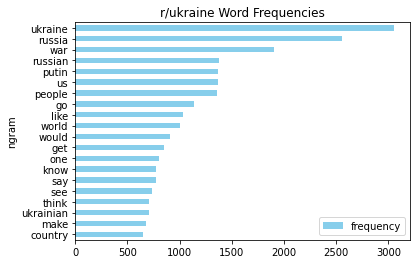

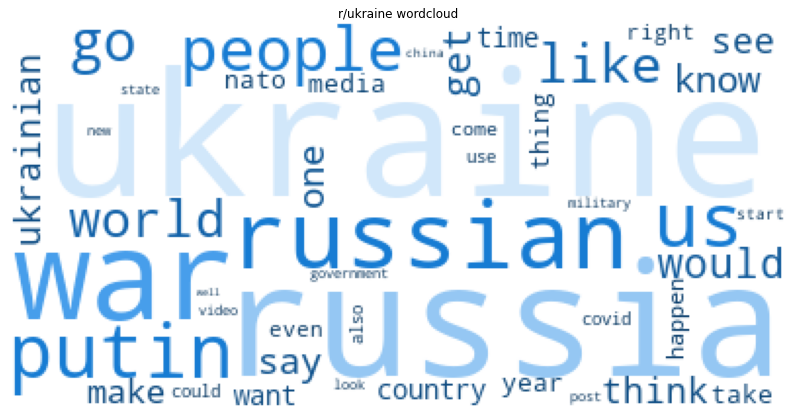

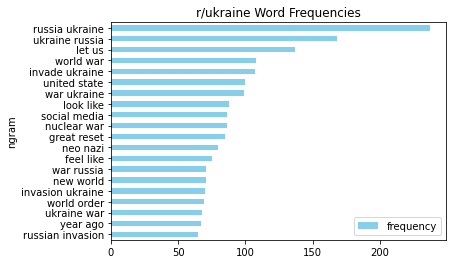

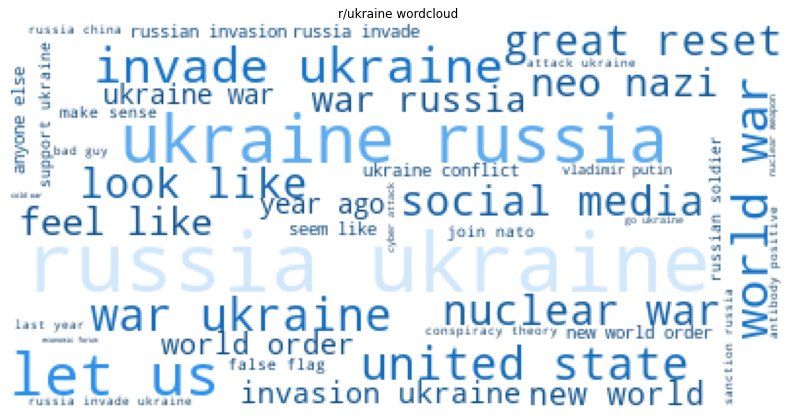

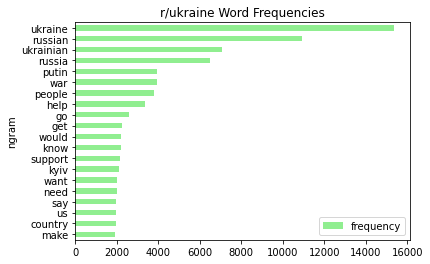

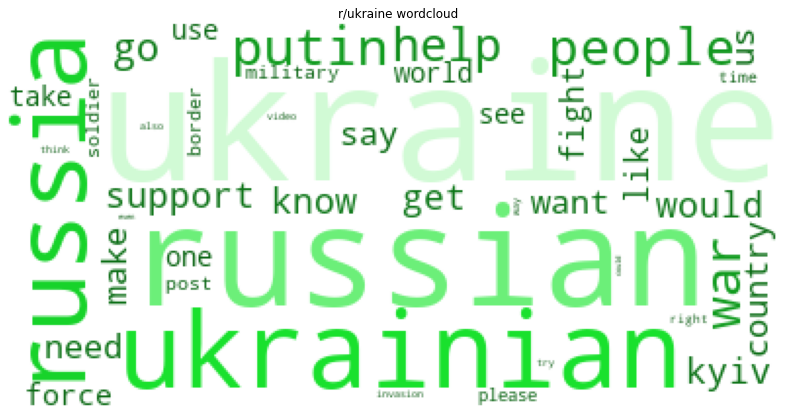

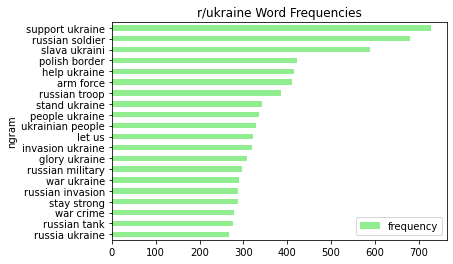

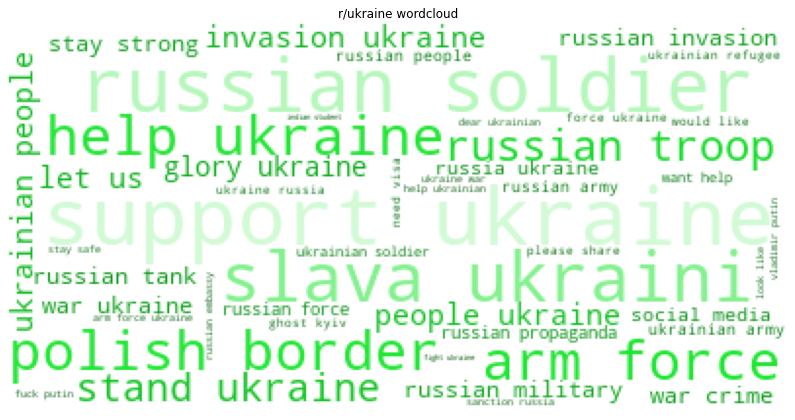

In [149]:
createWordCloud((1,1), None, submissions_c, "skyblue", 208)
createWordCloud((2,3), 10000, submissions_c, "skyblue", 208)
createWordCloud((1,1), None, submissions_u, "lightgreen", 126)
createWordCloud((2,3), 10000, submissions_u, "lightgreen", 126)

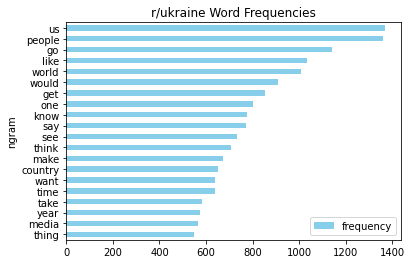

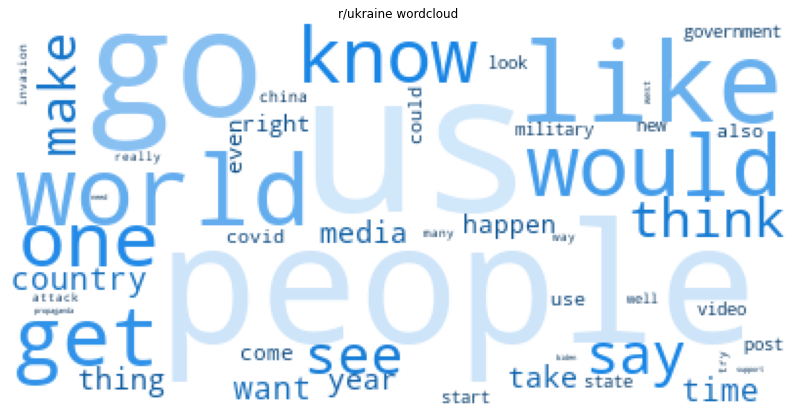

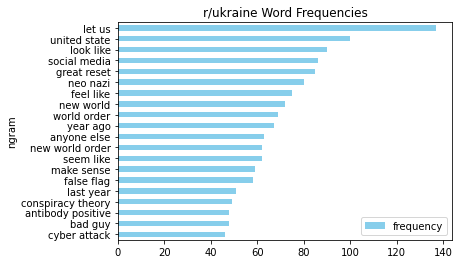

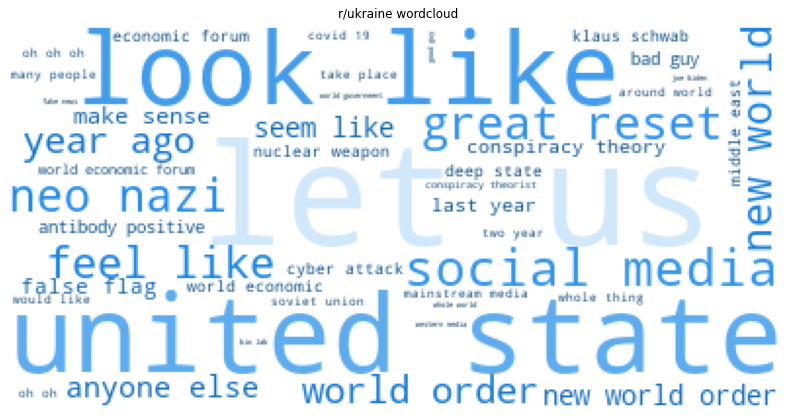

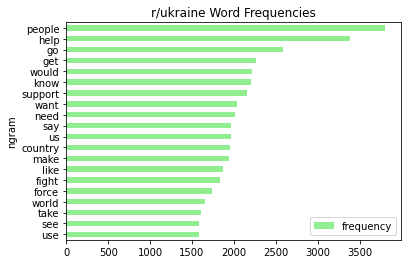

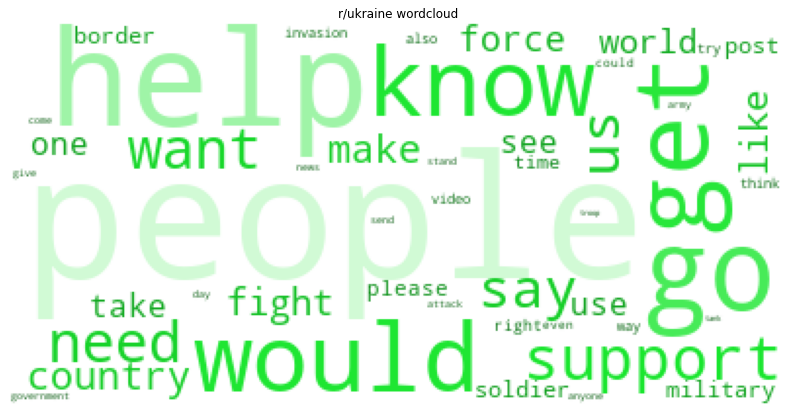

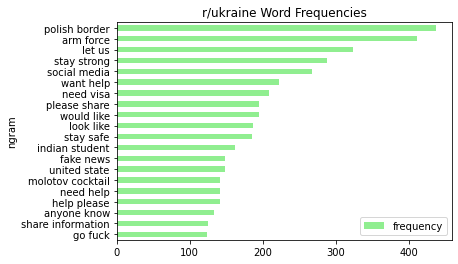

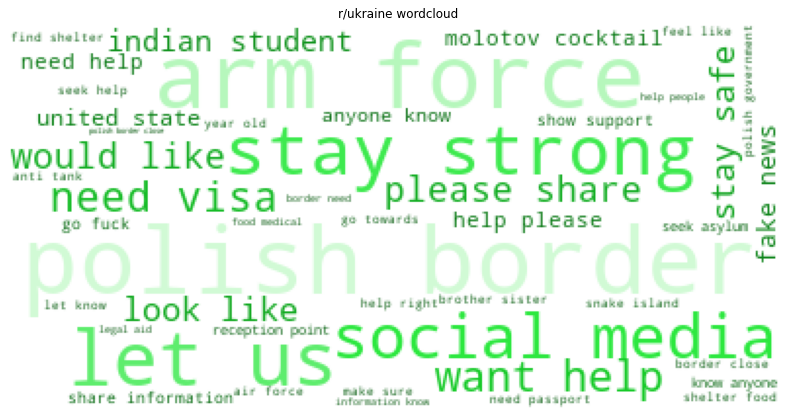

In [151]:
submissions_c_filt = removeStopWords(submissions_c, wordfilter)
submissions_u_filt = removeStopWords(submissions_u, wordfilter)

createWordCloud((1,1), None, submissions_c_filt, "skyblue", 208)
createWordCloud((2,3), 10000, submissions_c_filt, "skyblue", 208)
createWordCloud((1,1), None, submissions_u_filt, "lightgreen", 126)
createWordCloud((2,3), 10000, submissions_u_filt, "lightgreen", 126)

In [ ]:
def getPronouns(submissions, color, subreddit):
    countvec = CountVectorizer(ngram_range=(1,1), tokenizer=lambda txt: txt.split())
    ngrams = countvec.fit_transform(submissions)
    
    count_values = ngrams.toarray().sum(axis=0)
    vocab = countvec.vocabulary_
    df = pd.DataFrame([(k,count_values[i]) for k,i in vocab.items()]).rename(columns={0: 'ngram', 1:'frequency'})
    pronouns_dict = {'i': 0, 'you': 0, 'he': 0, 'she': 0, 'we': 0, 'they': 0}
    pronouns_dict['i'] = df[df['ngram'] == 'i']['frequency'].values[0]# + df['me'] + df['my'] + df['mine'] add i
    pronouns_dict['you'] = df[df['ngram'] == 'you']['frequency'].values[0]#  + df['yours'] + df['your']
    pronouns_dict['we'] = df[df['ngram'] == 'we']['frequency'].values[0]# + df['us'] + df['our'] + df['ours']
    pronouns_dict['they'] = df[df['ngram'] == 'they']['frequency'].values[0]# + df['them'] + df['their'] + df['theirs']
    pronouns_dict['he'] = df[df['ngram'] == 'he']['frequency'].values[0]# + df['him'] + df['his']
    pronouns_dict['she'] = df[df['ngram'] == 'she']['frequency'].values[0]# + df['her'] #+ df['hers']
    names = list(pronouns_dict.keys())
    values = list(pronouns_dict.values())
    print(pronouns_dict)
    sns.barplot(x=names, y=values, color=color)
    #plt.bar(range(len(pronouns_dict)), values, tick_label=names)
    
    plt.title(f"r/{subreddit} pronouns")
    #plt.savefig("./images/conspiracy_pronouns.png")
    plt.show()

{'i': 3445, 'you': 2204, 'he': 970, 'she': 96, 'we': 1632, 'they': 2335}


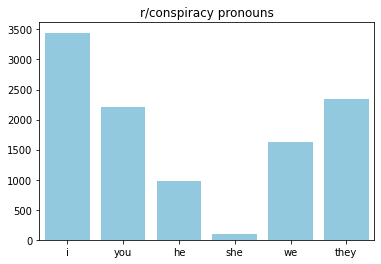

{'i': 13052, 'you': 8698, 'he': 2025, 'she': 346, 'we': 4201, 'they': 4400}


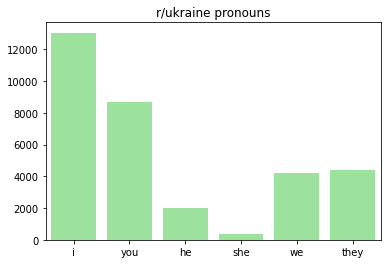

In [ ]:
getPronouns(wholetext_c, "skyblue", "conspiracy")
getPronouns(wholetext_u, "lightgreen", "ukraine")

covid always in connection to war! in r/conspiracy

todo: i.e. filter for only nouns
check which pronouns are prevalent